# SPARK: Resilient Ditributed Data (RDD)

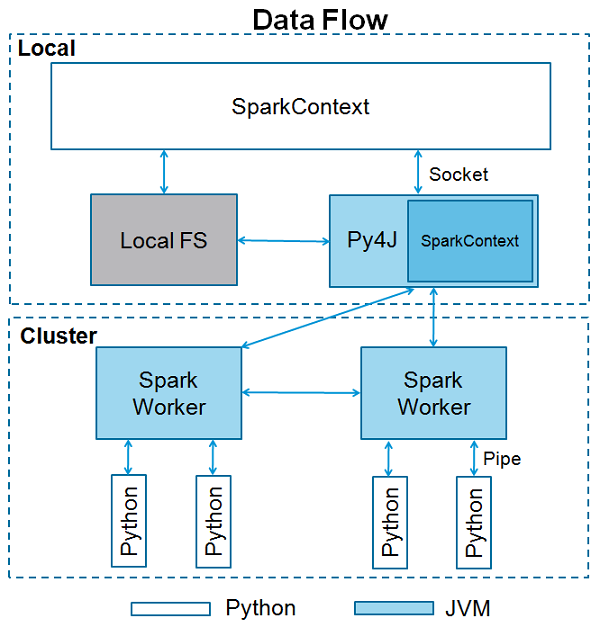

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=c11705861230d04298757c57c1e8f83aadbd6f1db0973ea3db5556765d32a995
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


### Creating Session and Context

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

### Words counts

In [3]:
import re #for splitting texts

We will use here a toy dataset for explaining the main concepts of RDDs:

In [4]:
text = sc.parallelize(["Humpty Dumpty sat on a wall",\
  	      "Humpty Dumpty had a great fall",\
  	      "All the King's horses and all the King's men",\
          "Couldn't put Humpty together again" ])

In [5]:
def countWords(line):
  D = {}
  for w in re.split('\W+', line.lower().strip()):
    ##Optional: REMOVE MEANINGLESS TOKENS HERE
    if w in D: D[w]+=1
    else: D[w]=1
  return [(w, D[w]) for w in D]

In [6]:
counts = text.flatMap(countWords) \
             .reduceByKey(lambda a, b: a + b)

counts.coalesce(1).saveAsTextFile("words_counts") #reduce partitions to 1
counts.take(3)

[('dumpty', 2), ('sat', 1), ('fall', 1)]

We are going to save the file in a CSV, so first we convert the RDD into a Dataframe:

In [7]:
df = counts.toDF().toDF('word','total')

In [8]:
df.take(5)

[Row(word='dumpty', total=2),
 Row(word='sat', total=1),
 Row(word='fall', total=1),
 Row(word='king', total=2),
 Row(word='s', total=2)]

In [9]:
df.write.options(header=True).mode('overwrite').csv('./word_counts_csv')

### Word probabilities:

First, we calculate the total number of occurrences in all the text:

In [10]:
N = text.map(lambda line: ("total", len(re.split('\W+', line.lower().strip())))) \
        .reduceByKey(lambda a, b: a + b)

total = N.take(1)[0][1]
total

29

Then, we divide all elements by the total occurrences:

In [11]:
total = N.take(1)[0][1]

P = counts.map(lambda x: (x[0], x[1]/total))

P.take(10)

[('dumpty', 0.06896551724137931),
 ('sat', 0.034482758620689655),
 ('fall', 0.034482758620689655),
 ('king', 0.06896551724137931),
 ('s', 0.06896551724137931),
 ('horses', 0.034482758620689655),
 ('couldn', 0.034482758620689655),
 ('put', 0.034482758620689655),
 ('again', 0.034482758620689655),
 ('humpty', 0.10344827586206896)]

**Definition:** The inverse document frequency (IDF) of a word is `-log(count(w)/total)`

Notice that rare words have a high IDF score and very frequent words have a low IDF score. We can filter out words with a extremely low IDF (also called stopwords).

In [12]:
import math

IDF = counts.map(lambda x: (x[0], -math.log(x[1]/total)))

In [13]:
IDF.take(4)

[('dumpty', 2.6741486494265287),
 ('sat', 3.367295829986474),
 ('fall', 3.367295829986474),
 ('king', 2.6741486494265287)]

### Conditional Probabilities


First, we count bigrams of adjacent words `count(w, w')`

In [14]:
def countBigrams(s):
    D = {}
    words = re.split('\W+', s.lower().strip())
    ##Optional: REMOVE MEANINGLESS TOKENS HERE
    for i in range(len(words) - 1):
        clave = (words[i], words[i + 1])
        if clave in D: D[clave] += 1
        else: D[clave] = 1
    return [(w, D[w]) for w in D]

In [15]:
countBigrams("Humpty Dumpty sat on a wall")

[(('humpty', 'dumpty'), 1),
 (('dumpty', 'sat'), 1),
 (('sat', 'on'), 1),
 (('on', 'a'), 1),
 (('a', 'wall'), 1)]

In [16]:
counts3 = text.flatMap(lambda line: countBigrams(line)) \
              .reduceByKey(lambda a, b: a + b)

'''
[(('dumpty', 'sat'), 1),
 (('on', 'a'), 1),
 (('a', 'wall'), 1),
 (('had', 'a'), 1),
 (('a', 'great'), 1)]
'''

"\n[(('dumpty', 'sat'), 1),\n (('on', 'a'), 1),\n (('a', 'wall'), 1),\n (('had', 'a'), 1),\n (('a', 'great'), 1)]\n"

Now, we take the second word as a key to be able to join with the probs. of words `count(w')`

In [17]:
counts4 = counts3.map(lambda x: (x[0][1], [x[0], x[1]] ))

'''
[('sat', [('dumpty', 'sat'), 1]),
 ('a', [('on', 'a'), 1]),
 ('wall', [('a', 'wall'), 1]),
 ('a', [('had', 'a'), 1]),
 ('great', [('a', 'great'), 1])]
'''

"\n[('sat', [('dumpty', 'sat'), 1]),\n ('a', [('on', 'a'), 1]),\n ('wall', [('a', 'wall'), 1]),\n ('a', [('had', 'a'), 1]),\n ('great', [('a', 'great'), 1])]\n"

Finally, we can calculate `count(w, w')/count(w)` from the previous RDD

In [18]:
conditional = counts4.join(counts) \
                     .map(lambda x: (x[1][0][0], x[1][0][1]/x[1][1]))

'''
join:
[('s', ([('king', 's'), 2], 2)),
 ('dumpty', ([('humpty', 'dumpty'), 2], 2)),
 ('king', ([('the', 'king'), 2], 2)),
 ...
'''

conditional.collect()

[(('king', 's'), 1.0),
 (('humpty', 'dumpty'), 1.0),
 (('the', 'king'), 1.0),
 (('t', 'put'), 1.0),
 (('together', 'again'), 1.0),
 (('on', 'a'), 0.5),
 (('had', 'a'), 0.5),
 (('a', 'wall'), 1.0),
 (('a', 'great'), 1.0),
 (('all', 'the'), 1.0),
 (('horses', 'and'), 1.0),
 (('s', 'men'), 1.0),
 (('dumpty', 'sat'), 1.0),
 (('s', 'horses'), 1.0),
 (('great', 'fall'), 1.0),
 (('and', 'all'), 0.5),
 (('humpty', 'together'), 1.0),
 (('sat', 'on'), 1.0),
 (('dumpty', 'had'), 1.0),
 (('couldn', 't'), 1.0),
 (('put', 'humpty'), 0.3333333333333333)]

### DATAFRAMES

In [19]:
words = spark.read.options(header=True)\
             .format("csv")\
             .load("word_counts_csv")

In [20]:
words

DataFrame[word: string, total: string]

In [21]:
rdd = words.rdd

In [22]:
rdd.map(lambda x: (x.word , x.total) ).take(1)

[('humpty', '3')]

In [23]:
#We can also convert a RDD to a Pandas dataframe

df_pandas = words.toPandas()

df_pandas.head()

,word,total
0,humpty,3
1,on,1
2,a,2
3,wall,1
4,had,1


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2b85c2dfec97e55c73b4e6f89b9b53213bbb4eebb9a28476ec0b02407e85c3a9
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


## Exercise

Give the compressed CSV available at `http://krono.act.uji.es/IDIA/criticas_pelis.csv.gz`, our aim is to tranform this data into *sparse vectors* suited for machine learning algorithms of Spark. The vector of each document will be represented with the following string:

`word_1:score_1 word_2:score_2 ...`

Where *word_i* is the position of the word in the list of all the words in the CSV, and *score_i* is the TFxIDF score. The TF is frequency of the *word_i* in the document, and the IDF is the inverse document frequecy of the *word_i* (see definition above).

Finally, we will write this data into a LIBSVM text file. This file consists of a labelled sample per line, where each sample has the following format:

`label word_1:score_1 word_2:score_2 ...`

To perform this task, you can follow the following steps:

**Step 1.** Load the CSV file as a Spark Dataframe, and assign as the ID of each document the position of its row.

In [2]:
!wget "http://krono.act.uji.es/IDIA/criticas_pelis.csv.gz"
!gunzip "criticas_pelis.csv.gz"

--2023-10-25 22:15:27--  http://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
Resolving krono.act.uji.es (krono.act.uji.es)... 150.128.97.37
Connecting to krono.act.uji.es (krono.act.uji.es)|150.128.97.37|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz [following]
--2023-10-25 22:15:27--  https://krono.act.uji.es/IDIA/criticas_pelis.csv.gz
Connecting to krono.act.uji.es (krono.act.uji.es)|150.128.97.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4447654 (4.2M) [application/x-gzip]
Saving to: ‘criticas_pelis.csv.gz’

criticas_pelis.csv. 100%[===================>]   4.24M  4.39MB/s    in 1.0s    

2023-10-25 22:15:29 (4.39 MB/s) - ‘criticas_pelis.csv.gz’ saved [4447654/4447654]



In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import split
from pyspark.sql.types import ArrayType, StringType, MapType, IntegerType, DoubleType
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
import re
import math
from google.colab import drive

In [4]:
## Step 1
# Initialize Spark session
spark = SparkSession.builder.appName("films").getOrCreate()

# Path to CSV file
csv = "criticas_pelis.csv"

# Load compressed CSV file into Spark DataFrame
df = spark.read.options(header=False).csv(csv)

# Assign IDs to the rows
df = df.withColumn("ID", monotonically_increasing_id())

df.show(5)

+----+---------+--------------------+---+---+
| _c0|      _c1|                 _c2|_c3| ID|
+----+---------+--------------------+---+---+
|Row0|   File-0| May, ¿quieres se...|  4|  0|
|Row1|   File-1| Cómo ponerse en ...|  4|  1|
|Row2|  File-10| Deliciosa comedi...|  4|  2|
|Row3| File-100| La ironía es el ...|  3|  3|
|Row4|File-1000| Al final, y teni...|  3|  4|
+----+---------+--------------------+---+---+
only showing top 5 rows



**Step 2.** Build an RDD to calculate the IDFs of all the words in the CSV

In [5]:
split_words_udf = udf(lambda line: re.split('\W+', line.lower().strip()), ArrayType(StringType()))
df = df.withColumn("words", split_words_udf(f.col("_c2")))

# Extract words from the DataFrame and create an RDD
words_rdd = df.select("words").rdd.flatMap(lambda x: x["words"])

df.show(5)
words_rdd.take(5)

+----+---------+--------------------+---+---+--------------------+
| _c0|      _c1|                 _c2|_c3| ID|               words|
+----+---------+--------------------+---+---+--------------------+
|Row0|   File-0| May, ¿quieres se...|  4|  0|[may, quieres, se...|
|Row1|   File-1| Cómo ponerse en ...|  4|  1|[cómo, ponerse, e...|
|Row2|  File-10| Deliciosa comedi...|  4|  2|[deliciosa, comed...|
|Row3| File-100| La ironía es el ...|  3|  3|[la, ironía, es, ...|
|Row4|File-1000| Al final, y teni...|  3|  4|[al, final, y, te...|
+----+---------+--------------------+---+---+--------------------+
only showing top 5 rows



['may', 'quieres', 'ser', 'mi', 'amigo']

In [6]:
# Calculate word counts in the RDD
word_counts = words_rdd.countByValue()

# Calculate total number of words in all documents
total_words = words_rdd.count()

In [7]:
# Calculate IDFs
idfs = {word: math.log(total_words / count) for word, count in word_counts.items()}
idfs = list(idfs.items())
idfs[:5]

[('may', 12.112513931014654),
 ('quieres', 10.276302699215764),
 ('ser', 6.138473025053925),
 ('mi', 6.946689535398657),
 ('amigo', 8.726584021483285)]

Although originally the IDF of a word was defined as the logarithm of the total number of documents in the collection divided by the number of documents that contain that word, this time the IDF of a word is defined as the logarithm of the total number of words in the corpus between the number of occurrences of that word in the corpus of documents.

This approach could be interesting in certain specific contexts, such as when working with few documents or when the documents are very short. In these situations, the frequency of occurrence of words in individual documents may be quite low due to the limited amount of text available. This can lead to traditional IDF not adequately capturing word importance, as the number of documents containing a specific word could be extremely low or even zero in a small data set.

In such cases, using the total number of words in the corpus in the denominator of the IDF might provide a better indication of the rarity of a word relative to the total length of the corpus, rather than its frequency in a small set of documents. This would help mitigate rarity issues and provide a more meaningful measure of word importance in the context of short or sparse documents.

**Step 3.** Build a Python dictionary to store the position and IDF of each word in the previous RDD. Word position corresponds to the index on the ordered list of all words in the CSV.

For example, if we name the dictionary `Vocab`, `Vocab["always"]` contains a tuple like `(1234, 3.2)`, where 1234 is the position of "always" in the ordered list of all the words in the CSV, and 3.2 is the IDF score of "always" according to the RDD of Step 2.

In [8]:
## Step 3
Vocab = {idf[0]: (index, idf[1]) for index, idf in enumerate(idfs, start=1)}

**Step 4.** Build an RDD with the words' scores of each document

You can modify the function `countWords(line)` and use the dictionary of Step 3
to obtain the position (word_id) and the IDF of each word in the document.

*Output*: key-value pairs `((doc_id, word_id), tf*IDF)`

In [9]:

## Step 4
# Define the countWords function
def countWords(line, vocab_dict, doc_id):
    D = {}
    words = re.split('\W+', line.lower().strip())
    total_words = len(words)
    for word in set(words):
        if word in vocab_dict:
            word_id, idf = vocab_dict[word]
            tf = words.count(word) / total_words
            D[(doc_id, word_id)] = tf * idf
    return list(D.items())

# Convert Vocab dictionary to broadcast variable for efficient access in Spark workers
vocab_broadcast = spark.sparkContext.broadcast(Vocab)

# Apply the countWords function to each document in the DataFrame and create an RDD of word scores
word_scores_rdd = df.rdd.flatMap(lambda row: countWords(row["_c2"], vocab_broadcast.value, row["ID"]))

word_scores_rdd.take(5)

[((0, 307), 0.010930046750619137),
 ((0, 110), 0.021732460947785293),
 ((0, 176), 0.016096336181388022),
 ((0, 297), 0.011559437256995498),
 ((0, 146), 0.019308869407365904)]

**Step 5**. Map and Reduce by document to create an ordered list of the words' ids along with their TF*IDF scores

*Output*: key-value pairs `(doc_id, [(word_1, score_1), (word_2, score_2)])`

In [33]:
## Step 5
# Map and Reduce by document to create an ordered list of words' ids along with their TF*IDF scores
doc_word_scores_rdd = word_scores_rdd \
    .map(lambda x: (x[0][0], [(x[0][1], x[1])])) \
    .reduceByKey(lambda x, y: x + y) \
    .mapValues(lambda x: sorted(x, key=lambda y: y[0])) \
    .sortByKey()

# Print the first 5 key-value pairs (doc_id, [(word_id_1, score_1), (word_id_2, score_2)])
doc_word_scores_rdd.take(1)


[(0,
  [(1, 0.14823006558934018),
   (2, 0.03593112831893624),
   (3, 0.021463192395293443),
   (4, 0.024289124249645654),
   (5, 0.04576879731547178),
   (6, 0.06077918740078642),
   (7, 0.11286535842896768),
   (8, 0.16871385936618072),
   (9, 0.027790087797619944),
   (10, 0.011696453171948024),
   (11, 0.11807406021151627),
   (12, 0.08461831795687981),
   (13, 0.01796556415946812),
   (14, 0.051786346066529786),
   (15, 0.06754444058749182),
   (16, 0.06188310156668094),
   (17, 0.012075192070056561),
   (18, 0.014545618527901882),
   (19, 0.02063349475998394),
   (20, 0.019480967436759703),
   (21, 0.08321059797210992),
   (22, 0.014774975538865781),
   (23, 0.019588779304294184),
   (24, 0.021965907438387607),
   (25, 0.12126861690577438),
   (26, 0.029282672422137355),
   (27, 0.1608960924584491),
   (28, 0.0168989897156546),
   (29, 0.055174815584807),
   (30, 0.016584840354836972),
   (31, 0.03531092610563388),
   (32, 0.04381806677802797),
   (33, 0.016858172645729794),
   (

**Step 6.** Map the previous RDD to replace the list by a string with the desired format

*Output*: key-value pairs `(doc_id, "word_1:score_1 word_2:score_2 ...")`

In [34]:
## Step 6
# Map the previous RDD to replace the list by a string with the desired format
doc_word_scores_formatted_rdd = doc_word_scores_rdd.map(lambda x: (x[0], " ".join([f"{word_id}:{score:.4f}" for word_id, score in x[1]])))
doc_word_scores_formatted_rdd.take(1)

[(0,
  '1:0.1482 2:0.0359 3:0.0215 4:0.0243 5:0.0458 6:0.0608 7:0.1129 8:0.1687 9:0.0278 10:0.0117 11:0.1181 12:0.0846 13:0.0180 14:0.0518 15:0.0675 16:0.0619 17:0.0121 18:0.0145 19:0.0206 20:0.0195 21:0.0832 22:0.0148 23:0.0196 24:0.0220 25:0.1213 26:0.0293 27:0.1609 28:0.0169 29:0.0552 30:0.0166 31:0.0353 32:0.0438 33:0.0169 34:0.0457 35:0.0269 36:0.0438 37:0.0212 38:0.0117 39:0.0407 40:0.0134 41:0.0160 42:0.0206 43:0.0159 44:0.0292 45:0.0193 46:0.0178 47:0.0200 48:0.0142 49:0.0127 50:0.0113 51:0.0112 52:0.0720 53:0.0147 54:0.0180 55:0.0194 56:0.0244 57:0.0152 58:0.0116 59:0.0191 60:0.0164 61:0.0138 62:0.0165 63:0.0116 64:0.0443 65:0.0133 66:0.0215 67:0.0254 68:0.0158 69:0.0184 70:0.0106 71:0.0208 72:0.0191 73:0.0204 74:0.0136 75:0.0183 76:0.0118 77:0.0139 78:0.0112 79:0.0140 80:0.0730 81:0.0190 82:0.0136 83:0.0161 84:0.0205 85:0.0286 86:0.0167 87:0.0234 88:0.0161 89:0.0307 90:0.0217 91:0.0186 92:0.0242 93:0.0124 94:0.0162 95:0.0169 96:0.0163 97:0.0151 98:0.0730 99:0.0251 100:0.0242 

**Step 7.** Join the document labels and the previous RDD by the document ids.

*Output*: key-value pairs `(doc_id, (label, "word_1:score_1 word_2:score_2 ..."))`

In [35]:
## Step 7
doc_labels_rdd = df.select("ID", "_c3").rdd.map(lambda row: (row["ID"], row["_c3"]))
#words_rdd = df.select("words").rdd.flatMap(lambda x: x["words"])
doc_labels_rdd.take(5)

[(0, '4'), (1, '4'), (2, '4'), (3, '3'), (4, '3')]

In [36]:
# Join the document labels RDD with the formatted word scores RDD by document IDs
joined_rdd = doc_labels_rdd.join(doc_word_scores_formatted_rdd)

# Rearrange the elements in the tuple to get the desired output format
joined_rdd = joined_rdd.map(lambda x: (x[0], (x[1][0], x[1][1])))

joined_rdd.take(1)

[(0,
  ('4',
   '1:0.1482 2:0.0359 3:0.0215 4:0.0243 5:0.0458 6:0.0608 7:0.1129 8:0.1687 9:0.0278 10:0.0117 11:0.1181 12:0.0846 13:0.0180 14:0.0518 15:0.0675 16:0.0619 17:0.0121 18:0.0145 19:0.0206 20:0.0195 21:0.0832 22:0.0148 23:0.0196 24:0.0220 25:0.1213 26:0.0293 27:0.1609 28:0.0169 29:0.0552 30:0.0166 31:0.0353 32:0.0438 33:0.0169 34:0.0457 35:0.0269 36:0.0438 37:0.0212 38:0.0117 39:0.0407 40:0.0134 41:0.0160 42:0.0206 43:0.0159 44:0.0292 45:0.0193 46:0.0178 47:0.0200 48:0.0142 49:0.0127 50:0.0113 51:0.0112 52:0.0720 53:0.0147 54:0.0180 55:0.0194 56:0.0244 57:0.0152 58:0.0116 59:0.0191 60:0.0164 61:0.0138 62:0.0165 63:0.0116 64:0.0443 65:0.0133 66:0.0215 67:0.0254 68:0.0158 69:0.0184 70:0.0106 71:0.0208 72:0.0191 73:0.0204 74:0.0136 75:0.0183 76:0.0118 77:0.0139 78:0.0112 79:0.0140 80:0.0730 81:0.0190 82:0.0136 83:0.0161 84:0.0205 85:0.0286 86:0.0167 87:0.0234 88:0.0161 89:0.0307 90:0.0217 91:0.0186 92:0.0242 93:0.0124 94:0.0162 95:0.0169 96:0.0163 97:0.0151 98:0.0730 99:0.0251 10

**Step 8.** Transform the final RDD to a dataframe and save it as a CSV file

In [37]:
## Step 8
# Transform the final RDD to a DataFrame
#final_df = joined_rdd.toDF(["doc_id", "word_scores"])
final_df = joined_rdd.map(lambda x: (x[0], x[1][0], x[1][1])) \
                     .toDF(['doc_id', 'rating', 'word_scores']) \
                     .orderBy('doc_id')

final_df.show(20)

+------+------+--------------------+
|doc_id|rating|         word_scores|
+------+------+--------------------+
|     0|     4|1:0.1482 2:0.0359...|
|     1|     4|3:0.0056 6:0.0876...|
|     2|     4|3:0.0212 6:0.1049...|
|     3|     3|3:0.0284 4:0.0160...|
|     4|     3|2:0.0121 3:0.0216...|
|     5|     1|4:0.0167 6:0.0417...|
|     6|     3|2:0.0247 4:0.0167...|
|     7|     3|3:0.0369 6:0.0522...|
|     8|     4|3:0.0103 6:0.0805...|
|     9|     4|3:0.0117 6:0.0414...|
|    10|     2|3:0.0112 5:0.0318...|
|    11|     4|3:0.0443 6:0.0471...|
|    12|     1|4:0.0239 6:0.0971...|
|    13|     2|6:0.1023 7:0.0506...|
|    14|     4|3:0.0167 6:0.0354...|
|    15|     5|4:0.0192 6:0.0240...|
|    16|     3|3:0.0278 6:0.0788...|
|    17|     3|3:0.0193 6:0.0410...|
|    18|     2|6:0.0914 7:0.0388...|
|    19|     3|6:0.0699 7:0.0577...|
+------+------+--------------------+
only showing top 20 rows



In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Save the DataFrame as a CSV file
output_path = '/content/drive/MyDrive/Master_23_24/Big_Data/films.csv'
#final_df.write.csv(output_path, header=True)
final_df.repartition(1).write.options(header=True).csv(output_path)

Plot TF*IDF Scores of Words in the First Document

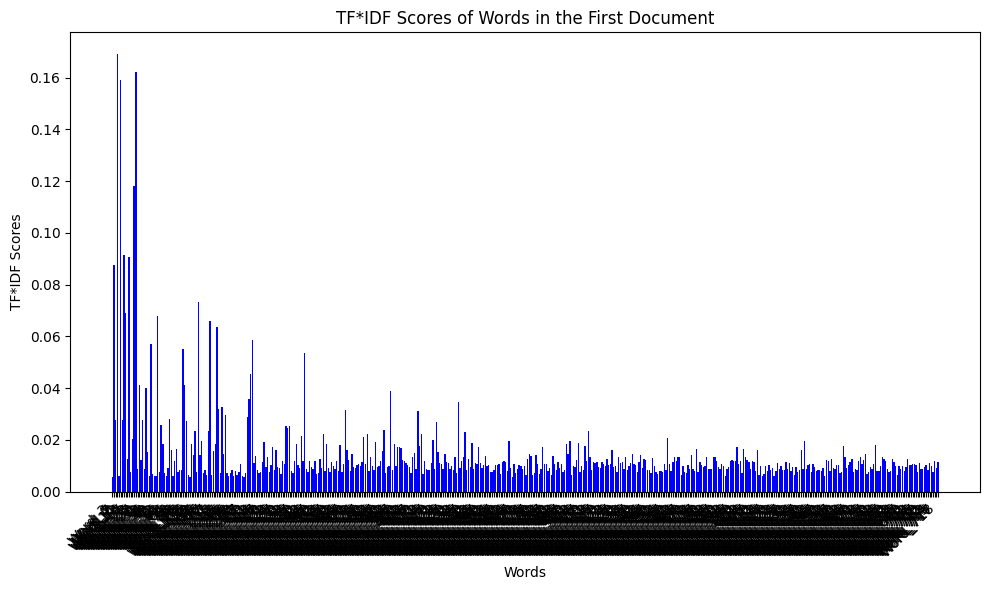

In [40]:
# Extract the word scores for the first document
first_document_scores = final_df.filter(final_df.doc_id == 1).select('word_scores').collect()[0]['word_scores']

# Parse the word scores string to a dictionary
word_scores_dict = dict(item.split(":") for item in first_document_scores.split())

# Convert scores from strings to floats
word_scores_dict = {int(key): float(value) for key, value in word_scores_dict.items()}

# Extract words and scores as separate lists for plotting
words = [f"Word_{word_id}" for word_id in word_scores_dict.keys()]
scores = list(word_scores_dict.values())

# Plotting the bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(words, scores, color='blue')
plt.xlabel('Words')
plt.ylabel('TF*IDF Scores')
plt.title('TF*IDF Scores of Words in the First Document')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


For the next notebook:

In [41]:
from pyspark.sql.functions import concat_ws, lit

## Create a new DataFrame with a single column 'libsvm'
libsvm_df = final_df.withColumn('libsvm', concat_ws(' ', final_df['rating'], final_df['word_scores']))

# Select only the 'libsvm' column
libsvm_df = libsvm_df.select('libsvm')

# Show the 'libsvm' DataFrame
libsvm_df.show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# Convert libsvm DataFrame to RDD
libsvm_rdd = libsvm_df.rdd

# Reduce the RDD to a single partition
libsvm_rdd = libsvm_rdd.coalesce(1)

# Convert the RDD back to DataFrame
libsvm_df = libsvm_rdd.toDF(["libsvm"])

# Save the DataFrame as a single text file without header
libsvm_output_path = "/content/drive/MyDrive/Master_23_24/Big_Data/filmsML.txt"  # Replace with your desired output path

# Save the DataFrame as a single text file without header
libsvm_df.write.mode("overwrite").option("header", "false").text(libsvm_output_path)
